In [24]:
import pandas as pd
import requests
import json
import seaborn as sns
import statistics
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

In [3]:
# Leitura de csv's com dados da TPU
classes_tpu  = pd.read_csv('tpu-classes.csv', sep=',')
classes_tpu.rename(columns={'codnivel1': 'classe_nivel1',
                            'codnivel2': 'classe_nivel2',
                            'codnivel3': 'classe_nivel3',
                            'codnivel4': 'classe_nivel4',
                            'codnivel5': 'classe_nivel5',
                            'codclasse': 'codclasse'}, inplace=True)

assuntos_tpu = pd.read_csv('assuntos-tpu.csv', sep=',')
assuntos_tpu.rename(columns={'codnivel1': 'assunto_nivel1',
                             'codnivel2': 'assunto_nivel2',
                             'codnivel3': 'assunto_nivel3',
                             'codnivel4': 'assunto_nivel4',
                             'codnivel5': 'assunto_nivel5',
                             'codassunto': 'codassunto'}, inplace=True)

# Códigos de movimentos, que segunda a TPU são referentes a julgamentos
movs_julgamento = [193,196,198,200,202,208,210,212,214,218,219,220,221,228,230,235,236,237,238,239,240,241,242,244,385,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,
 457,458,459,460,461,462,463,464,465,466,471,472,473,853,871,884,900,901,972,973,1042,1043,1044,1045,1046,1047,1048,1049,1050,10953,10961,10964,10965,11373,11374,
 11375,11376,11377,11378,11379,11380,11381,11394,11396,11401,11402,11403,11404,11405,11406,11407,11408,11409,11411,11795,11796,11801,11876,11877,11878,11879,12028,
 12032,12033,12034,12041,12184,12187,12252,12253,12254,12256,12257,12258,12298,12319,12321,12322,12323,12324,12325,12326,12327,12328,12329,12330,12331,12433,12434,
 12435,12436,12437,12438,12439,12440,12441,12442,12443,12450,12451,12452,12453,12458,12459,12475,12615,12616,12617,12649,12650,12651,12652,12653,12654,12660,12661,
 12662,12663,12664,12665,12666,12667,12668,12669,12670,12671,12672,12673,12674,12675,12676,12677,12678,12679,12680,12681,12682,12683,12684,12685,12686,12687,12688,
 12689,12690,12691,12692,12693,12694,12695,12696,12697,12698,12699,12700,12701,12702,12703,12704,12705,12706,12707,12708,12709,12710,12711,12712,12713,12714,12715,
 12716,12717,12718,12719,12720,12721,12722,12723,12724,12735,12738,12792,14099,14210,14211,14213,14214,14215,14216,14217,14218,14219,14680,14777,14778,14848,14937,
 15022,15023,15024,15026,15027,15028,15029,15030,15165,15166,15211,15212,15213,15214,15245,15249,15250,15251,15252,15253,15254,15255,15256,15257,15258,15259,15260,
 15261,15262,15263,15264,15265,15266,15322,15408,1002013,1003301,1003302,1050009,1050080,1050083,1050147,4050028,4050079,4050080,4050083,22,246]

movs_arquivamento = [22,246]
mov_evolucao_classe = 14739

# Variáveis para utilização da API do Datajud
headers = {
  'Authorization': 'ApiKey cDZHYzlZa0JadVREZDJCendQbXY6SkJlTzNjLV9TRENyQk1RdnFKZGRQdw==',
  'Content-Type': 'application/json'
}
tribunal = 'tjrr'


# Método para pegar apenas o primeiro assunto, pois o processo pode conter um assunto principal e N secundários
def extrair_assunto(assuntos):
  return assuntos[0]['codigo']


# Método para extrair a data de julgamento
def extrair_julgamento(movimentos):
  for movimento in movimentos:
    if movimento['codigo'] in movs_julgamento:
      return movimento['dataHora']
  return None


def load_data_from_datajud_api(tribunal, classe):
    url = f"https://api-publica.datajud.cnj.jus.br/api_publica_{tribunal}/_search"

    payload = json.dumps({
        "size":10000,
        "query": {
            "bool": {
                "must": [
                    {"match": {"classe.codigo": classe}}
                ]
            }
        }
    })

    response = requests.request("POST", url, headers=headers, data=payload)
    resposta = json.loads(response.text)
    # Os dados estão dentro de hits
    lista = resposta['hits']['hits']

    # Criando o DataFrame com os dados
    df = pd.DataFrame.from_records(lista)
    df = df['_source'].apply(pd.Series)

    # Muitos dados estão em json dentro da coluna do DataFrame, por isso são extraídos para novas colunas
    df[['codigo_classe','nome_classe']] = df['classe'].apply(pd.Series)
    df[['codigo_formato','nome_formato']] = df['formato'].apply(pd.Series)
    df[['orgao_codigoMunicipioIBGE','orgao_codigo','orgao_nome']] = df['orgaoJulgador'].apply(pd.Series)

    # Aplica os métodos para extrair os assuntos e data de julgamento
    df['data_julgamento'] = df['movimentos'].apply(extrair_julgamento)
    df['codigo_assunto'] = df['assuntos'].apply(extrair_assunto)

    # Conversão dos campos de data
    df['data_ajuizamento'] = pd.to_datetime(df['dataAjuizamento']).dt.strftime('%Y-%m-%d')
    df['data_julgamento'] = pd.to_datetime(df['data_julgamento']).dt.strftime('%Y-%m-%d')
    df['data_julgamento'] = pd.to_datetime(df['data_julgamento'])
    df['data_ajuizamento'] = pd.to_datetime(df['data_ajuizamento'])


    # Removendo colunas desnecessárias
    colunas_desnecessarias = ['@timestamp','id','sistema','dataHoraUltimaAtualizacao','dataAjuizamento',
                              'classe','nome_classe','formato','nome_formato',
                              'orgaoJulgador','orgao_codigoMunicipioIBGE','movimentos',
                              'nivelSigilo', 'assuntos']
    df.drop(columns=colunas_desnecessarias,inplace=True)

    # Removendo os processos que não tem julgamento
    df.dropna(subset=['data_julgamento'],inplace=True)

    # Criando coluna com o tempo de julgamento
    df['tempo_julgamento'] = (df['data_julgamento'] - df['data_ajuizamento']).dt.days


    # Fazendo join dos DataFrame de classes e assuntos da TPU
    df = pd.merge(df, assuntos_tpu, how='left', left_on='codigo_assunto', right_on='codassunto')
    df = pd.merge(df, classes_tpu, how='left',  left_on='codigo_classe', right_on='codclasse')

    df['numero_processo'] = df['numeroProcesso'].astype(str)
    df.drop(columns=['descclasse','descassunto','codclasse', 'codassunto','numeroProcesso'],inplace=True)

    return df


load_data_from_datajud_api(tribunal, 1116).to_csv('data.csv', index=False, doublequote=True)

In [39]:
df = pd.read_csv('data.csv')
pd.set_option('display.max_columns', None)

In [40]:
def categorizar_dias(dias):
    if dias <= 30:
        return 'Até 30 dias'
    elif 31 <= dias <= 60:
        return 'Entre 31 e 60 dias'
    elif 61 <= dias <= 180:
        return 'Entre 61 e 180 dias'
    elif 181 <= dias <= 365:
        return 'Entre 181 e 365 dias'
    elif 366 <= dias <= 730:
        return 'De 1 a 2 anos'
    elif 731 <= dias <= 1460:
        return 'De 2 a 4 anos'
    elif 1461 <= dias <= 3650:
        return 'De 4 a 10 anos'
    else:
        return 'Mais de 10 anos'

In [41]:
df['intervalo_julgamento'] = df['tempo_julgamento'].apply(categorizar_dias)
df['grau'] = df['grau'].replace({'JE': 0.5, 'G1': 1.0, 'TR': 1.5, 'G2': 2.0})
df.fillna(0, inplace=True)
df = df.drop(columns=["tribunal","orgao_nome","data_ajuizamento","data_julgamento","numero_processo"])

In [42]:
df

,grau,codigo_classe,codigo_formato,orgao_codigo,codigo_assunto,tempo_julgamento,assunto_nivel1,assunto_nivel2,assunto_nivel3,assunto_nivel4,assunto_nivel5,classe_nivel1,classe_nivel2,classe_nivel3,classe_nivel4,classe_nivel5,intervalo_julgamento
0,1.0,1116,1,2784,11786,4601,8826,11781.0,11786.0,0.0,0.0,2,158.0,1116.0,0.0,0.0,Mais de 10 anos
1,1.0,1116,1,2784,11786,6170,8826,11781.0,11786.0,0.0,0.0,2,158.0,1116.0,0.0,0.0,Mais de 10 anos
2,1.0,1116,1,2770,5951,4420,14,5916.0,5951.0,0.0,0.0,2,158.0,1116.0,0.0,0.0,Mais de 10 anos
3,1.0,1116,1,2784,11786,4502,8826,11781.0,11786.0,0.0,0.0,2,158.0,1116.0,0.0,0.0,Mais de 10 anos
4,1.0,1116,1,2784,11786,4502,8826,11781.0,11786.0,0.0,0.0,2,158.0,1116.0,0.0,0.0,Mais de 10 anos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,1.0,1116,1,84323,5946,403,14,5916.0,5946.0,0.0,0.0,2,158.0,1116.0,0.0,0.0,De 1 a 2 anos
3398,1.0,1116,1,84323,5946,287,14,5916.0,5946.0,0.0,0.0,2,158.0,1116.0,0.0,0.0,Entre 181 e 365 dias
3399,1.0,1116,1,2770,10395,191,9985,10394.0,10395.0,0.0,0.0,2,158.0,1116.0,0.0,0.0,Entre 181 e 365 dias
3400,1.0,1116,1,2770,10395,196,9985,10394.0,10395.0,0.0,0.0,2,158.0,1116.0,0.0,0.0,Entre 181 e 365 dias


In [19]:
#correlation_matrix = df.corr().round(2)

#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

ValueError: could not convert string to float: 'Mais de 10 anos'

In [43]:
x = df.drop(columns = ["intervalo_julgamento"])
y = df["intervalo_julgamento"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [44]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

y_predicoes = rf.predict(x_test)

In [45]:
print(classification_report(y_test, y_predicoes))

                      precision    recall  f1-score   support

         Até 30 dias       0.97      0.94      0.95        32
       De 1 a 2 anos       0.99      0.93      0.96        73
       De 2 a 4 anos       0.95      1.00      0.97        71
      De 4 a 10 anos       1.00      0.99      0.99       204
Entre 181 e 365 dias       0.99      0.98      0.98        98
  Entre 31 e 60 dias       0.94      1.00      0.97        32
 Entre 61 e 180 dias       0.99      0.99      0.99       100
     Mais de 10 anos       0.97      0.99      0.98        71

            accuracy                           0.98       681
           macro avg       0.97      0.98      0.97       681
        weighted avg       0.98      0.98      0.98       681



In [46]:
matriz_confusao = confusion_matrix(y_true = y_test,
                                   y_pred = y_predicoes,
                                   labels=[
                                       'Até 30 dias',
                                       'De 1 a 2 anos',
                                       'De 2 a 4 anos',
                                       'De 4 a 10 anos',
                                       'Entre 181 e 365 dias',
                                       'Entre 31 e 60 dias',
                                       'Mais de 10 anos'
                                       ]
                                   )
#Definindo a matriz de confusão.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Até 30 dias'),
  Text(1, 0, 'De 1 a 2 anos'),
  Text(2, 0, 'De 2 a 4 anos'),
  Text(3, 0, 'De 4 a 10 anos'),
  Text(4, 0, 'Entre 181 e 365 dias'),
  Text(5, 0, 'Entre 31 e 60 dias'),
  Text(6, 0, 'Mais de 10 anos')])

<Figure size 1500x500 with 0 Axes>

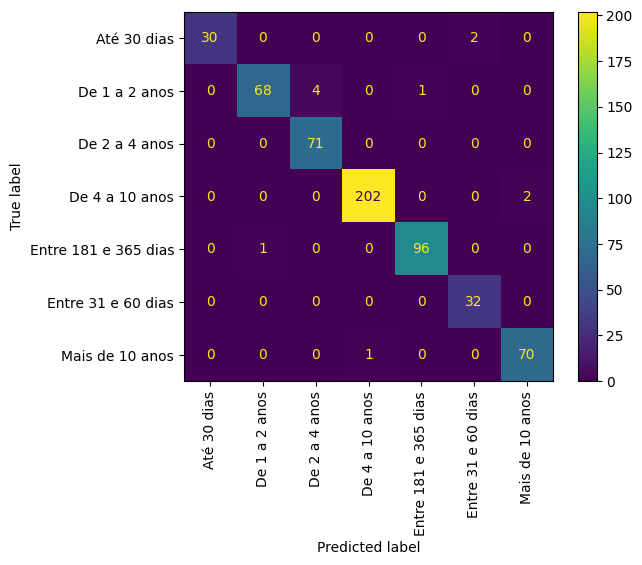

In [47]:
figure = plt.figure(figsize=(15, 5))
disp = ConfusionMatrixDisplay(confusion_matrix = matriz_confusao, display_labels=['Até 30 dias','De 1 a 2 anos','De 2 a 4 anos','De 4 a 10 anos','Entre 181 e 365 dias','Entre 31 e 60 dias','Mais de 10 anos'])
disp.plot(values_format='d')
plt.xticks(rotation=90)

In [48]:
joblib.dump(rf, "ml_datajud.pkl")

['ml_datajud.pkl']

In [49]:
modelo_carregado = joblib.load("ml_datajud.pkl")

In [50]:
teste_predicao = x_test.iloc[0:1]

In [51]:
teste_predicao

,grau,codigo_classe,codigo_formato,orgao_codigo,codigo_assunto,tempo_julgamento,assunto_nivel1,assunto_nivel2,assunto_nivel3,assunto_nivel4,assunto_nivel5,classe_nivel1,classe_nivel2,classe_nivel3,classe_nivel4,classe_nivel5
291,1.0,1116,1,2770,5946,5274,14,5916.0,5946.0,0.0,0.0,2,158.0,1116.0,0.0,0.0


In [52]:
previsoes = modelo_carregado.predict(teste_predicao)

In [53]:
previsoes

array(['Mais de 10 anos'], dtype=object)